In [1]:
import os
import torch
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import Visualizer
from tqdm import tqdm
from util.util import calc_psnr as calc_psnr
import time
import numpy as np
from collections import OrderedDict as odict
from copy import deepcopy

In [75]:
! find . -name "__pycache__" -exec rm -rf {} +
! find . -name "*.pyc" -delete

10258.44s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
10263.68s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


# Using model for inference

## Only lite isp net

In [1]:
import torch
import torch.nn as nn
import networks as N
class LiteISPNet(nn.Module):
	def __init__(self):
		super(LiteISPNet, self).__init__()
		# self.opt = opt
		ch_1 = 64
		ch_2 = 128
		ch_3 = 128
		n_blocks = 4
		# self.pre_ispnet_coord = opt.pre_ispnet_coord
		self.pre_ispnet_coord = False

		self.head = N.seq(
			N.conv(4, ch_1, mode='C')
		)  # shape: (N, ch_1, H/2, W/2)

		if self.pre_ispnet_coord:
			self.pre_coord = PreCoord(pre_train=True)

		self.down1 = N.seq(
			N.conv(ch_1+2, ch_1+2, mode='C'),
			N.RCAGroup(in_channels=ch_1+2, out_channels=ch_1+2, nb=n_blocks),
			N.conv(ch_1+2, ch_1, mode='C'),
			N.DWTForward(ch_1)
		)  # shape: (N, ch_1*4, H/4, W/4)

		self.down2 = N.seq(
			N.conv(ch_1*4, ch_1, mode='C'),
			N.RCAGroup(in_channels=ch_1, out_channels=ch_1, nb=n_blocks),
			N.DWTForward(ch_1)
		)  # shape: (N, ch_1*4, H/8, W/8)

		self.down3 = N.seq(
			N.conv(ch_1*4, ch_2, mode='C'),
			N.RCAGroup(in_channels=ch_2, out_channels=ch_2, nb=n_blocks),
			N.DWTForward(ch_2)
		)  # shape: (N, ch_2*4, H/16, W/16)

		self.middle = N.seq(
			N.conv(ch_2*4, ch_3, mode='C'),
			N.RCAGroup(in_channels=ch_3, out_channels=ch_3, nb=n_blocks),
			N.RCAGroup(in_channels=ch_3, out_channels=ch_3, nb=n_blocks),
			N.conv(ch_3, ch_2*4, mode='C')
		)  # shape: (N, ch_2*4, H/16, W/16)

		self.up3 = N.seq(
			N.DWTInverse(ch_2*4),
			N.RCAGroup(in_channels=ch_2, out_channels=ch_2, nb=n_blocks),
			N.conv(ch_2, ch_1*4, mode='C')
		)  # shape: (N, ch_1*4, H/8, W/8)

		self.up2 = N.seq(
			N.DWTInverse(ch_1*4),
			N.RCAGroup(in_channels=ch_1, out_channels=ch_1, nb=n_blocks),
			N.conv(ch_1, ch_1*4, mode='C')
		)  # shape: (N, ch_1*4, H/4, W/4)

		self.up1 = N.seq(
			N.DWTInverse(ch_1*4),
			N.RCAGroup(in_channels=ch_1, out_channels=ch_1, nb=n_blocks),
			N.conv(ch_1, ch_1, mode='C')
		)  # shape: (N, ch_1, H/2, W/2)

		self.tail = N.seq(
			N.conv(ch_1, ch_1*4, mode='C'),
			nn.PixelShuffle(upscale_factor=2),
			N.conv(ch_1, 3, mode='C')
		)  # shape: (N, 3, H, W)   

	def forward(self, raw, coord=None):
		# input = raw
		input = torch.pow(raw, 1/2.2)
		h = self.head(input)
		if self.pre_ispnet_coord:
			pre_coord = self.pre_coord(raw) * 0.1
			pre_coord = torch.clamp(pre_coord, -1, 1)
			pre_coord = pre_coord.unsqueeze(dim=2).unsqueeze(dim=3)
			pre_coord = pre_coord + coord
			h_coord = torch.cat((h, pre_coord), 1)
		else:
			h_coord = torch.cat((h, coord), 1)
		
		d1 = self.down1(h_coord)
		d2 = self.down2(d1)
		d3 = self.down3(d2)
		m = self.middle(d3) + d3
		u3 = self.up3(m) + d2
		u2 = self.up2(u3) + d1
		u1 = self.up1(u2) + h
		out = self.tail(u1)

		return out


In [2]:
model = LiteISPNet()
model.load_state_dict(torch.load('ckpt/zrrjoint/LiteISPNet_model_1.pth')['state_dict'])

<All keys matched successfully>

(448, 448, 3)
(448, 448, 3)


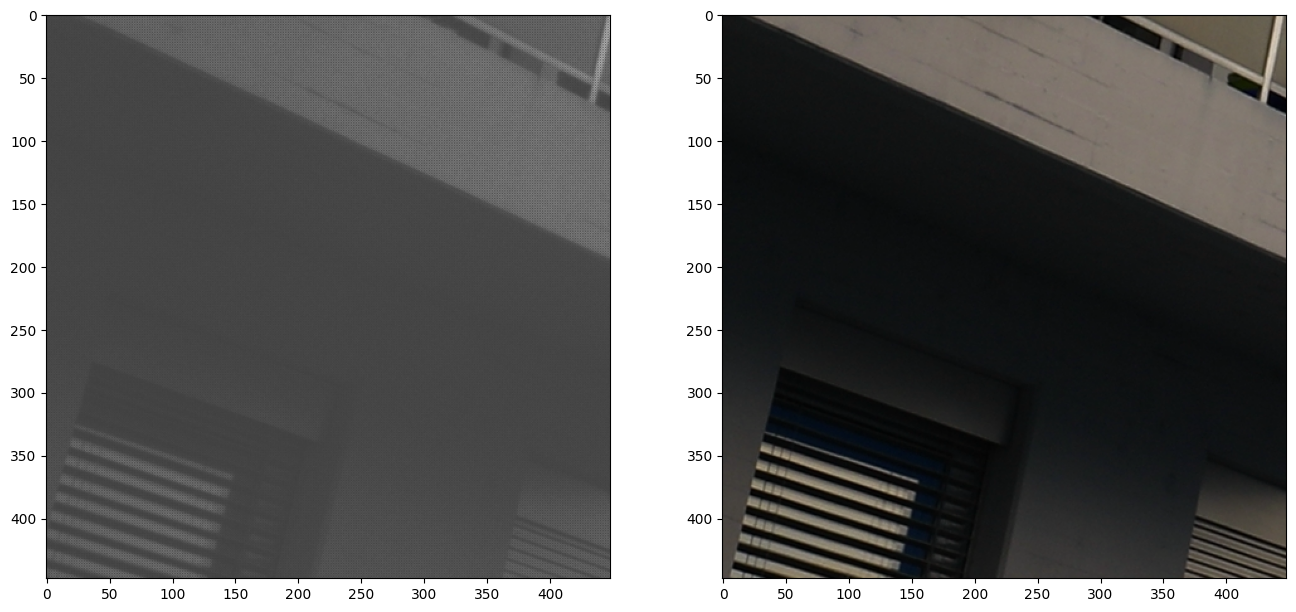

In [3]:
# ! ls ../Zurich-RAW-to-DSLR/train/huawei_raw/
import cv2
import matplotlib.pyplot as plt
import numpy as np

index = 9000
im_raw = cv2.imread(f'../Zurich-RAW-to-DSLR/train/huawei_raw/{index}.png')
im_proc = cv2.imread(f'../Zurich-RAW-to-DSLR/train/canon/{index}.jpg')

print(im_raw.shape)
print(im_proc.shape)

plt.figure(figsize=(16,10))
plt.subplot(1, 2, 1)
plt.imshow(im_raw)

plt.subplot(1, 2, 2)
plt.imshow(im_proc)
plt.show()

In [60]:
index = 9000
im_raw = cv2.imread(f'../Zurich-RAW-to-DSLR/train/huawei_raw/{index}.png')
im_proc = cv2.imread(f'../Zurich-RAW-to-DSLR/train/canon/{index}.jpg')

print(np.sum(im_raw[:, :, 0]))
print(np.sum(im_raw[:, :, 1]))
print(np.sum(im_raw[:, :, 2]))

print()
print(np.sum(im_proc[:, :, 0]))
print(np.sum(im_proc[:, :, 1]))
print(np.sum(im_proc[:, :, 2]))

15697326
15697326
15697326

9006443
8821215
8398298


In [ ]:
index = 9000

# 1. read H×W×C (uint8, BGR) → convert to RGB float32
im_raw = cv2.imread(f'../Zurich-RAW-to-DSLR/train/huawei_raw/{index}.png', cv2.IMREAD_UNCHANGED)
im_raw = cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB).astype('float32') / 255.0

# 2. H×W×C → torch, add batch
im_raw = torch.from_numpy(im_raw)          # (H, W, 3)
im_raw = im_raw.unsqueeze(0)               # (1, H, W, 3)

# 3. reorder to NCHW
im_raw = im_raw.permute(0, 3, 1, 2)        # (1, 3, H, W)

# 4. pad a zero channel to make 4 channels
zeros = torch.zeros_like(im_raw[:, :1, :, :])  
im_raw = torch.cat((im_raw, zeros), dim=1)  # (1, 4, H, W)

print(im_raw.shape)  

# model.eval()  
# with torch.no_grad():
#     out = model(im_raw) 

_, _, H, W = im_raw.shape
coord_dummy = torch.zeros((1, 2, H, W), device=im_raw.device)

with torch.no_grad():
    out = model(im_raw, coord=coord_dummy)


img = out[0].permute(1, 2, 0).cpu().numpy()  # (C, H, W) → (H, W, C)

plt.figure()
plt.imshow(img.clip(0, 1))  # assuming values are in [0,1]
plt.axis('off')
plt.show()
# im_raw

torch.Size([1, 4, 448, 448])


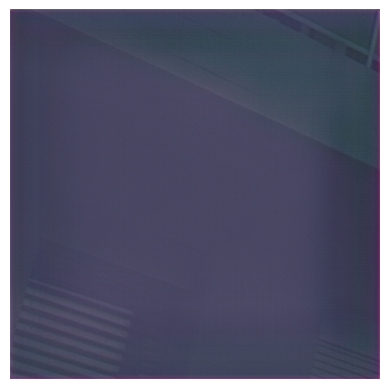

In [70]:
img = out[0].permute(1, 2, 0).cpu().numpy()  # (C, H, W) → (H, W, C)

plt.figure()
plt.imshow(img.clip(0, 1))  # assuming values are in [0,1]
plt.axis('off')
plt.show()

#### This is how the raw images are read from the disk

In [ ]:
# in class ZRRDataset
# self.coord = get_coord(H=448, W=448, x=1, y=1)
def get_coord(H, W, x=448/3968, y=448/2976):
    x_coord = np.linspace(-x + (x / W), x - (x / W), W)
    x_coord = np.expand_dims(x_coord, axis=0)
    x_coord = np.tile(x_coord, (H, 1))
    x_coord = np.expand_dims(x_coord, axis=0)

    y_coord = np.linspace(-y + (y / H), y - (y / H), H)
    y_coord = np.expand_dims(y_coord, axis=1)
    y_coord = np.tile(y_coord, (1, W))
    y_coord = np.expand_dims(y_coord, axis=0)

    coord = np.ascontiguousarray(np.concatenate([x_coord, y_coord]))
    coord = np.float32(coord)

    return coord


"""The cropped images have the shapes 448, 448, 3"""
def _getitem_visual(self, idx):
		# raw_combined is the thing fed into the liteisp model
        # is has the shape 4, 224, 224  raw_images[idx] has the shape [448, 448]
                                # in the code raw_images[idx] = cv2.imread(path)[-1] (each raw image has 3 exact same replicas)             
        raw_combined, raw_demosaic = self._process_raw(self.raw_images[idx])
        h, w = raw_demosaic.shape[-2:]
        coord = get_coord(H=h, W=w, x=1, y=1)

        return {'raw': raw_combined, # shape = 4, 224, 224
				'raw_demosaic': raw_demosaic,
				'dslr': raw_combined,
				'coord': coord,
				'fname': self.names[idx]}

def remove_black_level(img, black_lv=63, white_lv=4*255):
    img = np.maximum(img.astype(np.float32)-black_lv, 0) / (white_lv-black_lv)
    return img

def extract_bayer_channels(raw):  # HxW
    ch_R  = raw[0::2, 0::2]
    ch_Gb = raw[0::2, 1::2]
    ch_Gr = raw[1::2, 0::2]
    ch_B  = raw[1::2, 1::2]
    raw_combined = np.dstack((ch_B, ch_Gb, ch_R, ch_Gr))
    raw_combined = np.ascontiguousarray(raw_combined.transpose((2, 0, 1)))
    return raw_combined  # 4xHxW

def _process_raw(self, raw):
    raw = remove_black_level(raw)
    raw_combined = extract_bayer_channels(raw)
    raw_demosaic = get_raw_demosaic(raw)
    return raw_combined, raw_demosaic
    #         ^^^^^^^ the input to liteisp model of shape [4, 224, 224]

def set_input(self, input):
    self.data_raw = input['raw'].to(self.device) # <- this is the data_raw used by the model below
    self.data_raw_demosaic = input['raw_demosaic'].to(self.device)
    self.data_dslr = input['dslr'].to(self.device)
    self.data_gcm_coord = input['coord'].to(self.device)
    self.image_paths = input['fname']
        
    
self = 'hi'

# now for preparation of the self.data_ispnet_coord[index]
# we do this
def get_coord(H, W, x=448/3968, y=448/2976):
    x_coord = np.linspace(-x + (x / W), x - (x / W), W)
    x_coord = np.expand_dims(x_coord, axis=0)
    x_coord = np.tile(x_coord, (H, 1))
    x_coord = np.expand_dims(x_coord, axis=0)

    y_coord = np.linspace(-y + (y / H), y - (y / H), H)
    y_coord = np.expand_dims(y_coord, axis=1)
    y_coord = np.tile(y_coord, (1, W))
    y_coord = np.expand_dims(y_coord, axis=0)

    coord = np.ascontiguousarray(np.concatenate([x_coord, y_coord]))
    coord = np.float32(coord)

    return coord
# H = 224, W = 224
data_ispnet_coord = get_coord(H=H, W=W, x=1, y=1) # data_ispnet_coord.shape = (2, 224, 224)
data_ispnet_coord = np.expand_dims(data_ispnet_coord, axis=0) # data_ispnet_coord.shape = (1, 2, 224, 224)
data_ispnet_coord = np.tile(data_ispnet_coord, (N, 1, 1, 1)) # still (1, 2, 224, 224)
self.data_ispnet_coord[index] = torch.from_numpy(data_ispnet_coord).to(self.data_raw.device) # conversion of numpy to torch tensor

# then we pass both the raw and data_ispnet_coord to the model


# here is what their shapes look like

# self.data_ispnet_coord[index].shape
# torch.Size([1, 2, 224, 224])
# self.data_raw.shape
# torch.Size([1, 4, 224, 224])

self.data_out = self.netLiteISPNet(self.data_raw, self.data_ispnet_coord[index]) # important, this shows how the data is actually fed into the model


In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

def remove_black_level(img, black_lv=63, white_lv=4*255):
    img = np.maximum(img.astype(np.float32) - black_lv, 0)
    return img / (white_lv - black_lv)

def extract_bayer_channels(raw):
    ch_R  = raw[0::2, 0::2]
    ch_Gb = raw[0::2, 1::2]
    ch_Gr = raw[1::2, 0::2]
    ch_B  = raw[1::2, 1::2]
    raw_combined = np.stack((ch_B, ch_Gb, ch_R, ch_Gr), axis=2)
    return np.ascontiguousarray(raw_combined.transpose(2,0,1))

def get_coord(H, W, x=1, y=1):
    xs = np.linspace(-x + x/W, x - x/W, W, dtype=np.float32)
    ys = np.linspace(-y + y/H, y - y/H, H, dtype=np.float32)
    x_grid = np.repeat(xs[np.newaxis, :], H, axis=0)
    y_grid = np.repeat(ys[:, np.newaxis], W, axis=1)
    return np.stack((x_grid, y_grid), axis=0)

def run_liteisp_on_raw(model, raw_png_path, device='cpu'):
    model.to(device).eval()
    raw = cv2.imread(raw_png_path, cv2.IMREAD_UNCHANGED)
    if raw is None:
        raise FileNotFoundError(f"Can't read {raw_png_path}")
    if raw.ndim == 3:
        raw = raw[..., 0]
    raw_norm = remove_black_level(raw)
    raw_combined = extract_bayer_channels(raw_norm)
    _, H, W = raw_combined.shape
    coord_t = torch.from_numpy(get_coord(H, W)).unsqueeze(0).to(device)
    raw_t   = torch.from_numpy(raw_combined).unsqueeze(0).to(device)
    print(f'raw_t.shape: {raw_t.shape}')
    print(f'coord_t.shape: {coord_t.shape}')
    with torch.no_grad():
        out_t = model(raw_t, coord_t)
    out_np = out_t[0].permute(1,2,0).cpu().numpy()
    return np.clip(out_np,0,1), raw_norm

# — Load model once —
model = LiteISPNet()
checkpoint = torch.load('ckpt/zrrjoint/LiteISPNet_model_1.pth', map_location='cpu')
model.load_state_dict(checkpoint['state_dict'])

# — File paths —
index = 2
raw_path = f'../Zurich-RAW-to-DSLR/train/huawei_raw/{index}.png'
gt_path  = f'../Zurich-RAW-to-DSLR/train/canon/{index}.jpg'

# — Run model & prep visuals —
processed_img, raw_norm = run_liteisp_on_raw(model, raw_path)
raw_rgb = cv2.cvtColor((raw_norm * 255).astype(np.uint8),
                       cv2.COLOR_BAYER_BG2RGB) / 255.0
gt_bgr = cv2.imread(gt_path, cv2.IMREAD_COLOR)
gt_rgb = cv2.cvtColor(gt_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

# — Plot all three —
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title('Raw (demosaiced)')
plt.imshow(raw_rgb)
plt.axis('off')

plt.subplot(1,3,2)
plt.title('LiteISPNet Output')
plt.imshow(processed_img)
plt.axis('off')

plt.subplot(1,3,3)
plt.title('Ground Truth DSLR')
plt.imshow(gt_rgb)
plt.axis('off')

plt.tight_layout()
plt.show()


In [7]:
gt_rgb.shape

(448, 448, 3)

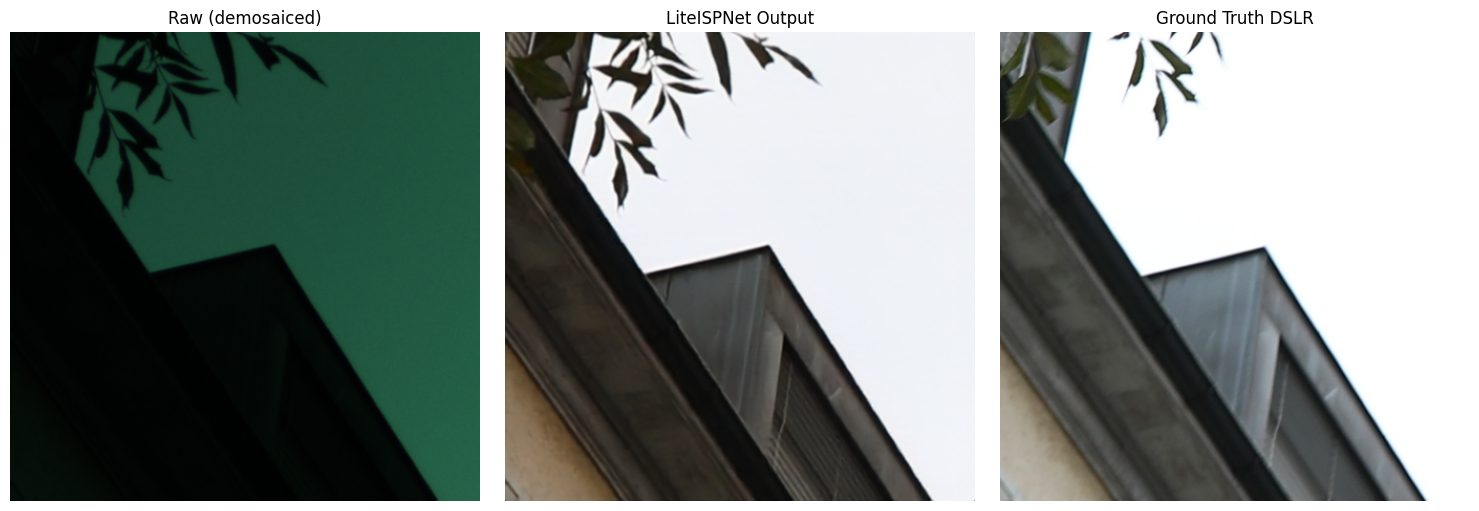

In [5]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Utilities
def remove_black_level(img, black_lv=63, white_lv=4*255):
    img = np.maximum(img.astype(np.float32) - black_lv, 0)
    return img / (white_lv - black_lv)

def extract_bayer_channels(raw):
    ch_R  = raw[0::2, 0::2]
    ch_Gb = raw[0::2, 1::2]
    ch_Gr = raw[1::2, 0::2]
    ch_B  = raw[1::2, 1::2]
    raw_combined = np.stack((ch_B, ch_Gb, ch_R, ch_Gr), axis=2)
    return np.ascontiguousarray(raw_combined.transpose(2,0,1))

def get_coord(H, W, x=1, y=1):
    xs = np.linspace(-x + x/W, x - x/W, W, dtype=np.float32)
    ys = np.linspace(-y + y/H, y - y/H, H, dtype=np.float32)
    x_grid = np.repeat(xs[np.newaxis, :], H, axis=0)
    y_grid = np.repeat(ys[:, np.newaxis], W, axis=1)
    return np.stack((x_grid, y_grid), axis=0)

# Core inference for a single raw image or full-res padded image
def run_liteisp_on_raw(model, raw_png_path=None, raw_array=None, device='cpu'):
    model.to(device).eval()
    if raw_array is None:
        raw = cv2.imread(raw_png_path, cv2.IMREAD_UNCHANGED)
        if raw is None:
            raise FileNotFoundError(f"Can't read {raw_png_path}")
    else:
        raw = raw_array
    if raw.ndim == 3:
        raw = raw[..., 0]
    raw_norm = remove_black_level(raw)
    raw_combined = extract_bayer_channels(raw_norm)
    _, H, W = raw_combined.shape
    coord_t = torch.from_numpy(get_coord(H, W)).unsqueeze(0).to(device)
    raw_t   = torch.from_numpy(raw_combined).unsqueeze(0).to(device)
    with torch.no_grad():
        out_t = model(raw_t, coord_t)
    out_np = out_t[0].permute(1,2,0).cpu().numpy()
    return np.clip(out_np,0,1), raw_norm

# Plotting function
def plot_comparison(raw_norm, processed_img, gt_path):
    raw_rgb = cv2.cvtColor((raw_norm * 255).astype(np.uint8), cv2.COLOR_BAYER_BG2RGB) / 255.0
    gt_bgr = cv2.imread(gt_path, cv2.IMREAD_COLOR)
    if gt_bgr is None:
        raise FileNotFoundError(f"Can't read {gt_path}")
    gt_rgb = cv2.cvtColor(gt_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    plt.figure(figsize=(15,5))
    for i, (img, title) in enumerate([
        (raw_rgb, 'Raw (demosaiced)'),
        (processed_img, 'LiteISPNet Output'),
        (gt_rgb, 'Ground Truth DSLR')
    ], 1):
        plt.subplot(1,3,i)
        plt.title(title)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Full-resolution single-pass inference with padding to multiples of 8

def run_full_resolution_single_pass(model, index, raw_dir, gt_dir, device='cpu'):  
    raw_path = f"{raw_dir}/{index}.jpg"
    gt_path  = f"{gt_dir}/{index}.jpg"
    full_raw = cv2.imread(raw_path, cv2.IMREAD_UNCHANGED)
    if full_raw is None:
        raise FileNotFoundError(f"Can't read {raw_path}")
    if full_raw.ndim == 3:
        full_raw = full_raw[..., 0]

    H, W = full_raw.shape
    # compute padded sizes
    H_pad = ((H + 7) // 8) * 8
    W_pad = ((W + 7) // 8) * 8
    pad_bottom = H_pad - H
    pad_right  = W_pad - W

    # pad raw image
    full_raw_padded = np.pad(full_raw, ((0, pad_bottom), (0, pad_right)), mode='constant', constant_values=0)

    # run model on padded full image
    output_padded, raw_norm_padded = run_liteisp_on_raw(model, raw_array=full_raw_padded, device=device)

    # crop back to original size
    output_full = output_padded[:H, :W, :]
    raw_norm = raw_norm_padded[:H, :W]
    return output_full, raw_norm, gt_path

# Example usage
if __name__ == '__main__':
    model = LiteISPNet()
    ckpt = torch.load('ckpt/zrrjoint/LiteISPNet_model_1.pth', map_location='cpu')
    model.load_state_dict(ckpt['state_dict'])

    idx = 2
    # single patch run
    proc, raw_norm = run_liteisp_on_raw(model, raw_png_path=f'../Zurich-RAW-to-DSLR/train/huawei_raw/{idx}.png')
    plot_comparison(raw_norm, proc, f'../Zurich-RAW-to-DSLR/train/canon/{idx}.jpg')

    # full-res single-pass run
    # raw_full_dir = '../Zurich-RAW-to-DSLR/full_resolution/huawei_isp'
    # gt_full_dir  = '../Zurich-RAW-to-DSLR/full_resolution/canon'
    # full_out, full_raw_norm, full_gt = run_full_resolution_single_pass(
    #     model, idx, raw_full_dir, gt_full_dir, device='cpu')
    # plot_comparison(full_raw_norm, full_out, full_gt)


In [6]:
raw_norm.shape

(448, 448)

In [ ]:
# torch.rand(1, 4, 224, 224).shape
h = 752
w = 1000
out = model(torch.rand(1, 4, h, w), torch.rand(1, 2, h, w))
print(out.shape)

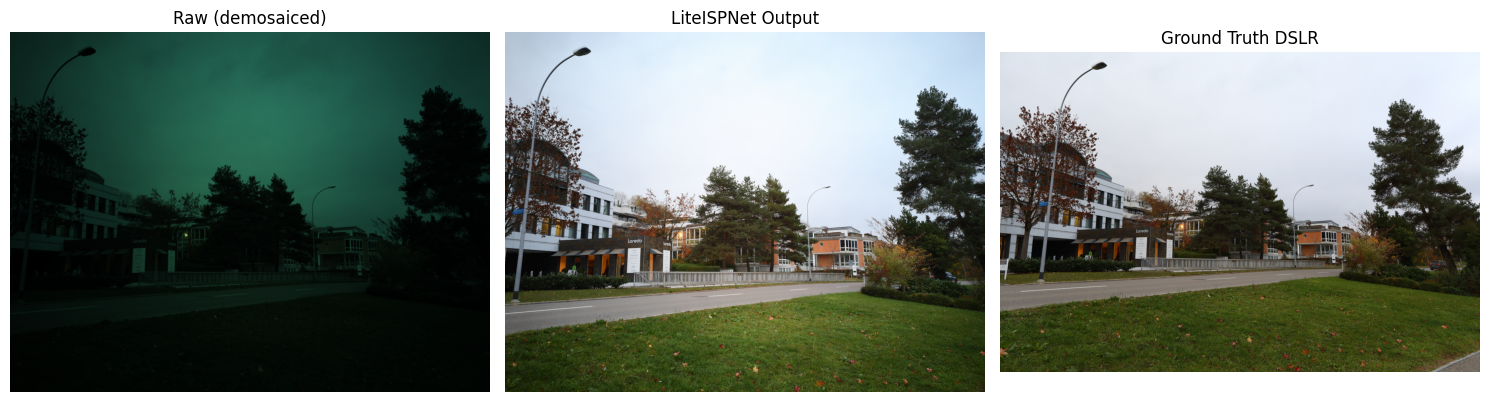

In [10]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

# Utilities
def remove_black_level(img, black_lv=63, white_lv=4*255):
    img = np.maximum(img.astype(np.float32) - black_lv, 0)
    return img / (white_lv - black_lv)

def extract_bayer_channels(raw):
    ch_R  = raw[0::2, 0::2]
    ch_Gb = raw[0::2, 1::2]
    ch_Gr = raw[1::2, 0::2]
    ch_B  = raw[1::2, 1::2]
    raw_combined = np.stack((ch_B, ch_Gb, ch_R, ch_Gr), axis=2)
    return np.ascontiguousarray(raw_combined.transpose(2,0,1))

def get_coord(H, W, x=1, y=1):
    xs = np.linspace(-x + x/W, x - x/W, W, dtype=np.float32)
    ys = np.linspace(-y + y/H, y - y/H, H, dtype=np.float32)
    x_grid = np.repeat(xs[np.newaxis, :], H, axis=0)
    y_grid = np.repeat(ys[:, np.newaxis], W, axis=1)
    return np.stack((x_grid, y_grid), axis=0)

# Core inference for a single raw image or full-res padded image
def run_liteisp_on_raw(model, raw_png_path=None, raw_array=None, device='cpu'):
    model.to(device).eval()
    if raw_array is None:
        raw = cv2.imread(raw_png_path, cv2.IMREAD_UNCHANGED)
        if raw is None:
            raise FileNotFoundError(f"Can't read {raw_png_path}")
    else:
        raw = raw_array
    if raw.ndim == 3:
        raw = raw[..., 0]
    raw_norm = remove_black_level(raw)
    raw_combined = extract_bayer_channels(raw_norm)
    _, H, W = raw_combined.shape
    coord_t = torch.from_numpy(get_coord(H, W)).unsqueeze(0).to(device)
    raw_t   = torch.from_numpy(raw_combined).unsqueeze(0).to(device)
    with torch.no_grad():
        out_t = model(raw_t, coord_t)
    out_np = out_t[0].permute(1,2,0).cpu().numpy()
    return np.clip(out_np,0,1), raw_norm

# Plotting function
def plot_comparison(raw_norm, processed_img, gt_path):
    raw_rgb = cv2.cvtColor((raw_norm * 255).astype(np.uint8), cv2.COLOR_BAYER_BG2RGB) / 255.0
    gt_bgr = cv2.imread(gt_path, cv2.IMREAD_COLOR)
    if gt_bgr is None:
        raise FileNotFoundError(f"Can't read {gt_path}")
    gt_rgb = cv2.cvtColor(gt_bgr, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    plt.figure(figsize=(15,5))
    for i, (img, title) in enumerate([
        (raw_rgb, 'Raw (demosaiced)'),
        (processed_img, 'LiteISPNet Output'),
        (gt_rgb, 'Ground Truth DSLR')
    ], 1):
        plt.subplot(1,3,i)
        plt.title(title)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Full-resolution single-pass inference with padding to multiples of 8

def run_full_resolution_single_pass(model, index, raw_dir, gt_dir, device='cpu'):  
    raw_path = f"{raw_dir}/{index}.png"
    gt_path  = f"{gt_dir}/{index}.jpg"
    full_raw = cv2.imread(raw_path, cv2.IMREAD_UNCHANGED)
    if full_raw is None:
        raise FileNotFoundError(f"Can't read {raw_path}")
    if full_raw.ndim == 3:
        full_raw = full_raw[..., 0]

    H, W = full_raw.shape
    # compute padded sizes
    H_pad = ((H + 7) // 8) * 8
    W_pad = ((W + 7) // 8) * 8
    pad_bottom = H_pad - H
    pad_right  = W_pad - W

    # pad raw image
    full_raw_padded = np.pad(full_raw, ((0, pad_bottom), (0, pad_right)), mode='constant', constant_values=0)

    # run model on padded full image
    output_padded, raw_norm_padded = run_liteisp_on_raw(model, raw_array=full_raw_padded, device=device)

    # crop back to original size
    output_full = output_padded[:H, :W, :]
    raw_norm = raw_norm_padded[:H, :W]
    return output_full, raw_norm, gt_path

# Example usage
if __name__ == '__main__':
    model = LiteISPNet()
    ckpt = torch.load('ckpt/zrrjoint/LiteISPNet_model_1.pth', map_location='cpu')
    model.load_state_dict(ckpt['state_dict'])

    idx = 244
    # single patch run
    # proc, raw_norm = run_liteisp_on_raw(model, raw_png_path=f'../Zurich-RAW-to-DSLR/train/huawei_raw/{idx}.png')
    # plot_comparison(raw_norm, proc, f'../Zurich-RAW-to-DSLR/train/canon/{idx}.jpg')

    # full-res single-pass run
    raw_full_dir = '../Zurich-RAW-to-DSLR/full_resolution/huawei_raw'
    gt_full_dir  = '../Zurich-RAW-to-DSLR/full_resolution/canon'
    full_out, full_raw_norm, full_gt = run_full_resolution_single_pass(
        model, idx, raw_full_dir, gt_full_dir, device='cpu')
    plot_comparison(full_raw_norm, full_out, full_gt)
